In [28]:
from collections import defaultdict
import csv
from sklearn import linear_model
from sklearn.decomposition import PCA
import scipy
import scipy.optimize
import numpy
import random

In [43]:
def readCSV(path):
  f = open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')
    
def calc_model_stats(pred,label):
    
    TP,FP,TN,FN = calc_metrics(pred,label)

    # print("Stats")
    # print(TP,FP,TN,FN)

    # print("Predict N: {} ({}%)".format(TN+FN,(TN+FN)/(TP+TN+FP+FN)))
    # print("Predict P: {} ({}%)".format(TP+FP,(TP+FP)/(TP+TN+FP+FN)))

    accuracy, TPR, TNR, BER = calc_error_rates(TP, FP, TN, FN)

    print("Accuracy: {}".format(accuracy))
    # print("TPR: {}".format(TPR))
    # print("TNR: {}".format(TNR))
    # print("BER: {}".format(BER))
    
    return
 
def calc_metrics(predictions, labels):
    # Calculate True positives, false positives, etc.

    TP_ = numpy.logical_and(predictions, labels)
    FP_ = numpy.logical_and(predictions, numpy.logical_not(labels))
    TN_ = numpy.logical_and(numpy.logical_not(predictions), numpy.logical_not(labels))
    FN_ = numpy.logical_and(numpy.logical_not(predictions), labels)

    TP=sum(TP_)
    FP=sum(FP_)
    TN=sum(TN_)
    FN=sum(FN_)
    
    return TP,FP,TN,FN

def calc_error_rates(TP, FP, TN, FN):
    # Calculate accuracy, TPR, TNR and BER
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    BER = 1.0 - (TPR+TNR)/2
    
    return accuracy, TPR, TNR, BER


### Split Training Dataset into Train and Validation Datasets

In [44]:
dataset = []

for user,book,rating in readCSV("assignment1/train_Interactions.csv"):
  dataset.append([user,book,rating])

random.shuffle(dataset)

X = [values[0:2] for values in dataset]
y = [int(values[-1]) for values in dataset]

N = len(dataset)
Ntrain = 190001

Xtrain = X[:Ntrain]
Xvalid = X[Ntrain:]

ytrain = y[:Ntrain]
yvalid = y[Ntrain:]

print(N, len(ytrain),len(yvalid))

200000 190001 9999


### Adopt code from Workbook 4

In [45]:
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)

for user,book,rating in dataset:
    ratingsPerUser[user].append(rating)
    ratingsPerItem[book].append(rating)

N = len(Xtrain)
nUsers = len(ratingsPerUser)
nItems = len(ratingsPerItem)
users = list(ratingsPerUser.keys())
items = list(ratingsPerItem.keys())

print (nUsers, nItems)
print (users[:3])
print (items[:3])

11357 7170
['u60163487', 'u43184247', 'u26502664']
['b98496253', 'b92209314', 'b94088584']


In [46]:
ratingMean = sum([y for y in ytrain])/len(ytrain)

print("Mean of ratings in training set: {}".format(ratingMean))

Mean of ratings in training set: 3.8963426508281533


## K = 1

In [47]:
alpha = ratingMean

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

userGamma = {}
itemGamma = {}

K = 1

# Initialize user and item Gammas
for u in ratingsPerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
for i in ratingsPerItem:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

In [48]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    global userGamma
    global itemGamma
    index = 0
    alpha = theta[index]
    index += 1
    userBiases = dict(zip(users, theta[index:index+nUsers]))
    index += nUsers
    itemBiases = dict(zip(items, theta[index:index+nItems]))
    index += nItems
    for u in users:
        userGamma[u] = theta[index:index+K]
        index += K
    for i in items:
        itemGamma[i] = theta[index:index+K]
        index += K
        
def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item] + inner(userGamma[user], itemGamma[item])

   
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xtrain]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in users:
        cost += lamb*userBiases[u]**2
        for k in range(K):
            cost += lamb*userGamma[u][k]**2
    for i in items:
        cost += lamb*itemBiases[i]**2
        for k in range(K):
            cost += lamb*itemGamma[i][k]**2
    return cost


def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(dataset)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    dUserGamma = {}
    dItemGamma = {}
    for u in ratingsPerUser:
        dUserGamma[u] = [0.0 for k in range(K)]
    for i in ratingsPerItem:
        dItemGamma[i] = [0.0 for k in range(K)]
    for value in zip(Xtrain,ytrain):
        x,rating = value
        u = x[0]
        i = x[1]
        pred = prediction(u, i)
        diff = pred - rating
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
        for k in range(K):
            dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
            dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        for k in range(K):
            dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    for u in users:
        dtheta += dUserGamma[u]
    for i in items:
        dtheta += dItemGamma[i]
    return numpy.array(dtheta)

In [16]:
lamb = 0.001
theta_init = [alpha] + [0.0]*(nUsers+nItems) +  \
            [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))]
scipy.optimize.fmin_l_bfgs_b(cost, theta_init, derivative, args = (ytrain, lamb))

MSE = 1.4765490193751099
MSE = 1.4606364710776734
MSE = 8.967859681871094
MSE = 1.4591346200772974
MSE = 1.3677428000449716
MSE = 1.3672542490505748
MSE = 1.3654879401592468
MSE = 1.3638402882278156
MSE = 1.3641382233627937
MSE = 1.363928261790367
MSE = 1.3642953476841342
MSE = 1.3639875294052421
MSE = 1.363939957829823
MSE = 1.3639306577197992
MSE = 1.3639287563274232
MSE = 1.3639283640256947
MSE = 1.3639282829319872
MSE = 1.3639282661626693
MSE = 1.363928262694558
MSE = 1.3639282619772106
MSE = 1.3639282618288702
MSE = 1.363928261798207
MSE = 1.3639282617920343
MSE = 1.3639282617906197
MSE = 1.3639282617904016
MSE = 1.363928261790368
MSE = 1.363928261790368
MSE = 1.3639282617903852
MSE = 1.3639282617903683
MSE = 1.3639282617903683
MSE = 1.3639291279908072
MSE = 1.3639325980903845
MSE = 1.3639298509155207
MSE = 1.363929280774454
MSE = 1.36392965704182
MSE = 1.3639293601689337
MSE = 1.363929280774454


(array([ 3.87860867e+00, -1.52219967e-02,  6.07051488e-02, ...,
        -2.66208278e-05, -7.15064324e-05,  7.06443796e-04]),
 1.4127966891376775,
 {'funcalls': 37,
  'grad': array([-1.92748925e-05, -5.21393619e-07,  8.22469930e-07, ...,
         -6.22932132e-08, -1.36993040e-07,  1.41211902e-06]),
  'nit': 7,
  'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'warnflag': 0})

In [ ]:
lamb_values = [1e-4, 5e-5, 4e-5, 3e-5, 2e-5, 1e-5]
MSE_valid =[]
thetas=[]
best_theta = []
best_MSE = 0

for lamb in lamb_values:
    print("Lambda = {}".format(lamb))
  
    theta_init = [alpha] + [0.0]*(nUsers+nItems) +  \
            [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))]
    unpack(theta_init)
    
    def cost(theta, labels, lamb):
        unpack(theta)
        predictions = [prediction(user, book) for user,book in Xtrain]
        cost = MSE(predictions, labels)
        print("MSE = " + str(cost))
        for u in users:
            cost += lamb*userBiases[u]**2
            for k in range(K):
                cost += lamb*userGamma[u][k]**2
        for i in items:
            cost += lamb*itemBiases[i]**2
            for k in range(K):
                cost += lamb*itemGamma[i][k]**2
        return cost

    def derivative(theta, labels, lamb):
        unpack(theta)
        N = len(dataset)
        dalpha = 0
        dUserBiases = defaultdict(float)
        dItemBiases = defaultdict(float)
        dUserGamma = {}
        dItemGamma = {}
        for u in ratingsPerUser:
            dUserGamma[u] = [0.0 for k in range(K)]
        for i in ratingsPerItem:
            dItemGamma[i] = [0.0 for k in range(K)]
        for value in zip(Xtrain,ytrain):
            x,rating = value
            u = x[0]
            i = x[1]
            pred = prediction(u, i)
            diff = pred - rating
            dalpha += 2/N*diff
            dUserBiases[u] += 2/N*diff
            dItemBiases[i] += 2/N*diff
            for k in range(K):
                dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
                dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
        for u in userBiases:
            dUserBiases[u] += 2*lamb*userBiases[u]
            for k in range(K):
                dUserGamma[u][k] += 2*lamb*userGamma[u][k]
        for i in itemBiases:
            dItemBiases[i] += 2*lamb*itemBiases[i]
            for k in range(K):
                dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
        dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
        for u in users:
            dtheta += dUserGamma[u]
        for i in items:
            dtheta += dItemGamma[i]
        return numpy.array(dtheta)
    
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(cost, theta_init, derivative, args = (ytrain, lamb))
    thetas.append(theta)  # save thetas

    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xvalid]
    cost = MSE(predictions, yvalid)
    
    if best_MSE is 0:
        best_MSE = cost
        best_theta = theta
        print("Save best theta...")
    else:
        if cost < best_MSE:
            best_MSE = cost
            best_theta = theta
            print("Save best theta...")
    
    MSE_valid.append(cost)
    print(cost)

Lambda = 0.0001
MSE = 1.474232216254457
MSE = 1.4567938035377301
MSE = 1.393069979809257
MSE = 7.590384346300666
MSE = 1.378082058291567
MSE = 1.222156565950124
MSE = 1.2202780642231572
MSE = 1.2129330598904562
MSE = 1.1862570802267833
MSE = 1.0965231615012963
MSE = 1.0767573795097025
MSE = 1.0652119813413938
MSE = 1.0655786830954044
MSE = 1.0660110984476932
MSE = 1.06499375879217
MSE = 1.064052769208807
MSE = 1.064110840726799
MSE = 1.0649990005432952
MSE = 1.0641382875338816
MSE = 1.0641124642535371
MSE = 1.0641109395623212
MSE = 1.0641108467540226
MSE = 1.0641108410944373
MSE = 1.064110840749211
MSE = 1.0641108407281727
MSE = 1.0641108407269213
MSE = 1.0641108407268018
MSE = 1.0641108407268018
MSE = 1.064110840726862
MSE = 1.0641108407268043
MSE = 1.0641108407268018
MSE = 1.0641108407268032
MSE = 1.0641108407268018
Save best theta...
1.162528230066069
Lambda = 5e-05
MSE = 1.4774467937331324
MSE = 2.339042739237115
MSE = 1.474112451134349
MSE = 1.4739051031846924
MSE = 1.473320004796

In [35]:
for lamb, MSE in zip(lamb_values ,MSE_valid):
    print ("Lamb-{} gives MSE of {}".format(lamb, MSE))

Lamb-0.0001 gives MSE of 1.2062335515094293
Lamb-8e-05 gives MSE of 1.1849198394197724
Lamb-6e-05 gives MSE of 1.1640195356795948
Lamb-5e-05 gives MSE of 1.1517628738346761
Lamb-4e-05 gives MSE of 1.1416211951646362
Lamb-3e-05 gives MSE of 1.1319360011706632
Lamb-2e-05 gives MSE of 1.2126882848404716
Lamb-1e-05 gives MSE of 1.2957233676309137


In [36]:
best_MSE

1.1319360011706632

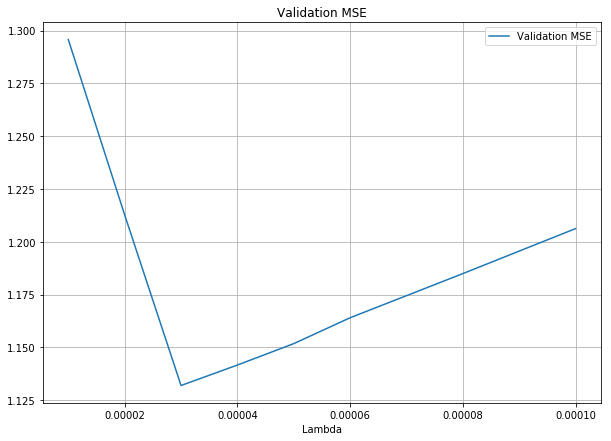

In [39]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

plt.xlabel('Lambda')
plt.title('Validation MSE')
plt.grid(True)

plt.plot(lamb_values, MSE_valid, label='Validation MSE')

plt.legend()
plt.show()

In [27]:
### Rating baseline: compute averages for each user, or return 
### the global average if we've never seen the user before

predictions = open("assignment1/predictions_Rating.txt", 'w')
unpack(best_theta)

for l in open("assignment1/pairs_Rating.txt"):
  # write header  
  if l.startswith("userID"):
    predictions.write(l)
    continue
    
  # write user-item-rating
  u,b = l.strip().split('-')
  predictions.write(u + '-' + b + ',' + str(prediction(u,b)) + '\n')

predictions.close()

In [42]:
unpack(best_theta)
predictions = [prediction(user, book) for user,book in Xvalid]
MSE(predictions, yvalid)

1.1319360011706632